In [3]:
import numpy as np
import pandas as pd
from typing import Mapping, List, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
    load_breast_cancer, load_diabetes, fetch_mldata
from  matplotlib.collections import LineCollection
import time
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from pdpbox import pdp
from rfpimp import *
from scipy.integrate import cumtrapz
from stratx.partdep import *
from stratx.ice import *

%config InlineBackend.figure_formats = ['svg','png']

from stratx.support import *

In [2]:
X, y = load_rent(n=10_000)

Rent has 49352 records


In [5]:
np.unique(X['bathrooms'], return_counts=True)

(array([0. , 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ]),
 array([  54, 8151,  140, 1539,   39,   67,    3,    7]))

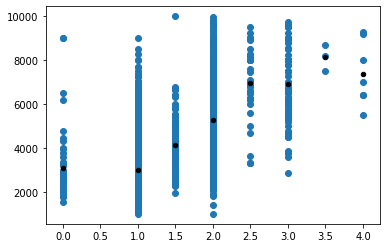

In [15]:
plt.scatter(X['bathrooms'],y)
df = pd.concat([X,y], axis=1)
avg_per_baths = df.groupby('bathrooms').mean()['price']
plt.scatter(np.unique(X['bathrooms']), avg_per_baths, s=20, c='black')
plt.show()

In [60]:
X, y = load_bulldozer(n=20_000)
df = pd.concat([X,y], axis=1)

Loading cached version...


In [61]:
df.describe()

,ModelID,datasource,YearMade,auctioneerID,MachineHours,age,AC,ProductSize,MachineHours_na,saleyear,salemonth,saleday,saledayofweek,saledayofyear,SalePrice
count,20000.000000,20000.000000,20000.00000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,8673.528850,146.174050,1999.60600,6.95360,4417.714100,11.043000,0.387300,1.415450,0.492250,2010.649000,7.193000,16.968100,2.397500,204.523650,33378.769550
std,7664.890284,15.413599,7.59302,20.08954,3970.576004,7.599845,0.487145,1.692629,0.499952,0.477295,3.255807,8.398542,1.209821,98.205359,24641.219495
min,28.000000,121.000000,1951.00000,0.00000,4.000000,0.000000,0.000000,0.000000,0.000000,2010.000000,1.000000,1.000000,0.000000,4.000000,4750.000000
25%,3350.000000,132.000000,1997.00000,1.00000,3138.000000,6.000000,0.000000,0.000000,0.000000,2010.000000,5.000000,10.000000,1.000000,134.000000,15000.000000
50%,4700.000000,149.000000,2002.00000,1.00000,3138.000000,8.000000,0.000000,0.000000,0.000000,2011.000000,7.000000,17.000000,2.000000,208.000000,25500.000000
75%,14272.000000,149.000000,2005.00000,3.00000,4322.500000,14.000000,1.000000,3.000000,1.000000,2011.000000,10.000000,24.000000,3.000000,282.000000,44500.000000
max,37196.000000,172.000000,2011.00000,99.00000,155250.000000,60.000000,1.000000,5.000000,1.000000,2011.000000,12.000000,31.000000,6.000000,364.000000,142000.000000


In [70]:
np.nanmean(X['MachineHours']), np.nanmedian(X['MachineHours'])

(4417.7141, 3138.0)

In [63]:
np.mean(X[X['MachineHours_na']==0]['YearMade']), np.mean(X[X['MachineHours_na']==1]['YearMade'])

(2000.8525849335304, 1998.3201625190452)

In [64]:
np.median(df[X['MachineHours_na']==0]['SalePrice']), np.median(df[X['MachineHours_na']==1]['SalePrice'])

(27000.0, 24000.0)

In [65]:
X['YearMade'].mean()

1999.606

In [66]:
sum(X['MachineHours_na']==1), len(X)

(9845, 20000)

In [67]:
X[X['MachineHours_na']==0].describe()

,ModelID,datasource,YearMade,auctioneerID,MachineHours,age,AC,ProductSize,MachineHours_na,saleyear,salemonth,saleday,saledayofweek,saledayofyear
count,10155.000000,10155.000000,10155.000000,10155.000000,10155.000000,10155.000000,10155.000000,10155.000000,10155.0,10155.000000,10155.000000,10155.000000,10155.000000,10155.000000
mean,9208.113639,148.294830,2000.852585,5.433875,5658.362580,9.775874,0.455933,1.465288,0.0,2010.628459,7.144264,16.753914,2.361989,202.801280
std,7949.870669,19.061048,6.154791,17.484720,5284.315556,6.187551,0.498079,1.701548,0.0,0.483240,3.283254,8.336979,1.182788,98.996259
min,28.000000,121.000000,1959.000000,0.000000,4.000000,1.000000,0.000000,0.000000,0.0,2010.000000,1.000000,1.000000,0.000000,4.000000
25%,3259.000000,132.000000,1998.000000,1.000000,2197.000000,5.000000,0.000000,0.000000,0.0,2010.000000,4.000000,10.000000,1.000000,118.000000
50%,4794.000000,149.000000,2003.000000,1.000000,4247.000000,8.000000,0.000000,0.000000,0.0,2011.000000,7.000000,16.000000,3.000000,207.000000
75%,15145.500000,172.000000,2005.000000,3.000000,7529.500000,13.000000,1.000000,3.000000,0.0,2011.000000,10.000000,24.000000,3.000000,286.000000
max,37196.000000,172.000000,2010.000000,99.000000,155250.000000,52.000000,1.000000,5.000000,0.0,2011.000000,12.000000,31.000000,6.000000,363.000000


In [68]:
X[X['MachineHours_na']==1].describe()

,ModelID,datasource,YearMade,auctioneerID,MachineHours,age,AC,ProductSize,MachineHours_na,saleyear,salemonth,saleday,saledayofweek,saledayofyear
count,9845.000000,9845.000000,9845.000000,9845.000000,9845.0,9845.000000,9845.000000,9845.000000,9845.0,9845.000000,9845.000000,9845.000000,9845.000000,9845.000000
mean,8122.111021,143.986491,1998.320163,8.521178,3138.0,12.350025,0.316506,1.364043,1.0,2010.670188,7.243271,17.189030,2.434129,206.300254
std,7318.987335,9.923361,8.648603,22.355020,0.0,8.630396,0.465136,1.681921,0.0,0.470169,3.226647,8.456315,1.236078,97.355928
min,28.000000,121.000000,1951.000000,0.000000,3138.0,0.000000,0.000000,0.000000,1.0,2010.000000,1.000000,1.000000,0.000000,6.000000
25%,3356.000000,132.000000,1995.000000,1.000000,3138.0,6.000000,0.000000,0.000000,1.0,2010.000000,5.000000,10.000000,2.000000,145.000000
50%,4639.000000,149.000000,2001.000000,1.000000,3138.0,10.000000,0.000000,0.000000,1.0,2011.000000,7.000000,17.000000,2.000000,208.000000
75%,12524.000000,149.000000,2005.000000,3.000000,3138.0,15.000000,1.000000,3.000000,1.0,2011.000000,10.000000,25.000000,3.000000,280.000000
max,36850.000000,172.000000,2011.000000,99.000000,3138.0,60.000000,1.000000,5.000000,1.0,2011.000000,12.000000,31.000000,6.000000,364.000000


In [69]:
hours = X[X['MachineHours']!=3138]['MachineHours']
hours

361861    2335.0
387540    5061.0
374932    3456.0
383824     821.0
374965     952.0
           ...  
372240    9243.0
390437    1905.0
379506    3857.0
388951    1818.0
370817    5274.0
Name: MachineHours, Length: 10153, dtype: float64

In [51]:
hours = hours.clip(0,25000)

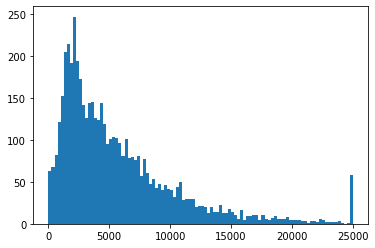

In [52]:
plt.hist(hours.astype(int), bins=100)
plt.show()

In [54]:
ux, cx = np.unique(hours.astype(int).values, return_counts=True)
print(list(ux))

[5, 15, 18, 24, 26, 29, 33, 34, 37, 39, 41, 42, 44, 48, 53, 60, 63, 64, 74, 77, 78, 80, 82, 87, 97, 102, 112, 125, 127, 134, 160, 198, 204, 208, 211, 217, 224, 231, 233, 235, 240, 242, 244, 245, 249, 261, 262, 267, 270, 273, 278, 288, 290, 297, 300, 301, 304, 308, 313, 317, 320, 321, 325, 327, 343, 356, 370, 375, 381, 384, 391, 397, 400, 416, 418, 420, 424, 428, 436, 437, 439, 442, 448, 450, 456, 458, 462, 464, 465, 471, 472, 473, 481, 484, 489, 491, 494, 496, 500, 512, 514, 520, 521, 522, 523, 525, 530, 533, 535, 538, 542, 543, 544, 545, 547, 548, 550, 551, 555, 582, 589, 593, 594, 596, 601, 606, 615, 617, 618, 621, 623, 624, 626, 636, 643, 644, 647, 648, 651, 653, 655, 659, 664, 668, 671, 672, 675, 678, 682, 689, 694, 695, 697, 698, 700, 701, 703, 704, 706, 714, 715, 720, 721, 722, 723, 725, 727, 728, 732, 733, 734, 745, 747, 750, 760, 765, 769, 770, 772, 773, 779, 780, 782, 787, 790, 791, 795, 800, 805, 806, 808, 809, 814, 815, 816, 820, 821, 822, 826, 828, 832, 834, 836, 839, 844, 